In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
from anndata import AnnData
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from pathlib import Path
import cell2location

/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this

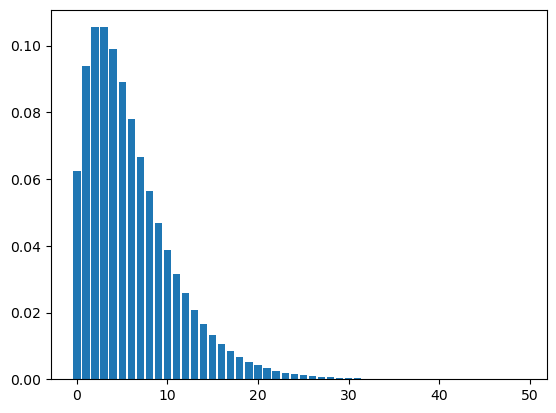

In [66]:
import torch
r = 2 # number of successful trials
p = 0.25 # probability of success
nb = torch.distributions.NegativeBinomial(total_count=r, probs=(1-p))
plt.bar(list(range(50)), torch.exp(nb.log_prob(torch.Tensor(list(range(50))))))
plt.show()

In [52]:
torch.exp(nb.log_prob(torch.Tensor(list(range(10)))))

NameError: name 'nb' is not defined

In [3]:
current_folder = globals()['_dh'][0]
path_deconv = current_folder / ".." / ".." / "data" / "prc" / "vis" / "c2l_out" / "cellranger"
visium_samples = [f for f in os.listdir(path_deconv) if not f.startswith(".")]

In [4]:
smp = visium_samples[0]
os.listdir(path_deconv / smp)

['cell_props_MS.csv',
 'cell_abunds_All.csv',
 'cell_abunds_MS.csv',
 'cell_props_All.csv',
 'c2l_mod',
 'sp.h5ad',
 'cell_abunds_CA.csv',
 'cell_props_CA.csv']

In [10]:
# unfortunately I did not specify here the exact model
adata_vis = sc.read_h5ad(path_deconv / smp / "sp.h5ad")
mod = cell2location.models.Cell2location.load(str(path_deconv / smp / "c2l_mod"), adata_vis)

INFO     File                                                                                                      
         /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/c2l_out/cellranger/MS377I/c2l_mod/m
         odel.pt already downloaded                                                                                


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_st

Epoch 1/30000:   0%|          | 1/30000 [00:03<28:48:50,  3.46s/it, v_num=1, elbo_train=4.68e+7]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:03<28:50:53,  3.46s/it, v_num=1, elbo_train=4.68e+7]


In [11]:
mod._adata

AnnData object with n_obs × n_vars = 4691 × 18347
    obs: 'in_tissue', 'array_row', 'array_col', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [ ]:
# also check c2l code for export_posterior

In [32]:
mod.factor_names_

array(['Asrtos_r', 'Astros', 'Astros_c', 'Astros_n', 'B_cells',
       'Endothelia', 'Macros', 'Microglia', 'Neurons', 'OPC', 'Oligos',
       'Stroma', 'T_cells'], dtype=object)

In [19]:
# by default this function actually only return 5% quantile, mean, 95% quantile and std but NOT the actual samples
# NOTE: return_samples=True can lead to very large objects if we don't specify return_sites
test = mod.sample_posterior(num_samples=1000, return_sites=["w_sf"], return_samples=True)

Sampling global variables, sample: 100%|██████████| 999/999 [00:12<00:00, 80.94it/s]


In [21]:
test.keys()

dict_keys(['posterior_samples', 'post_sample_means', 'post_sample_stds', 'post_sample_q05', 'post_sample_q95'])

In [35]:
# for spot 0
df = pd.DataFrame(test["posterior_samples"]["w_sf"][:, 0, :])
df.columns = mod.factor_names_
df = df.melt(var_name="factor", value_name="value")
df

,factor,value
0,Asrtos_r,0.190832
1,Asrtos_r,0.134990
2,Asrtos_r,0.139949
3,Asrtos_r,0.050957
4,Asrtos_r,0.016913
...,...,...
12995,T_cells,0.237736
12996,T_cells,0.082623
12997,T_cells,0.019924
12998,T_cells,0.025696


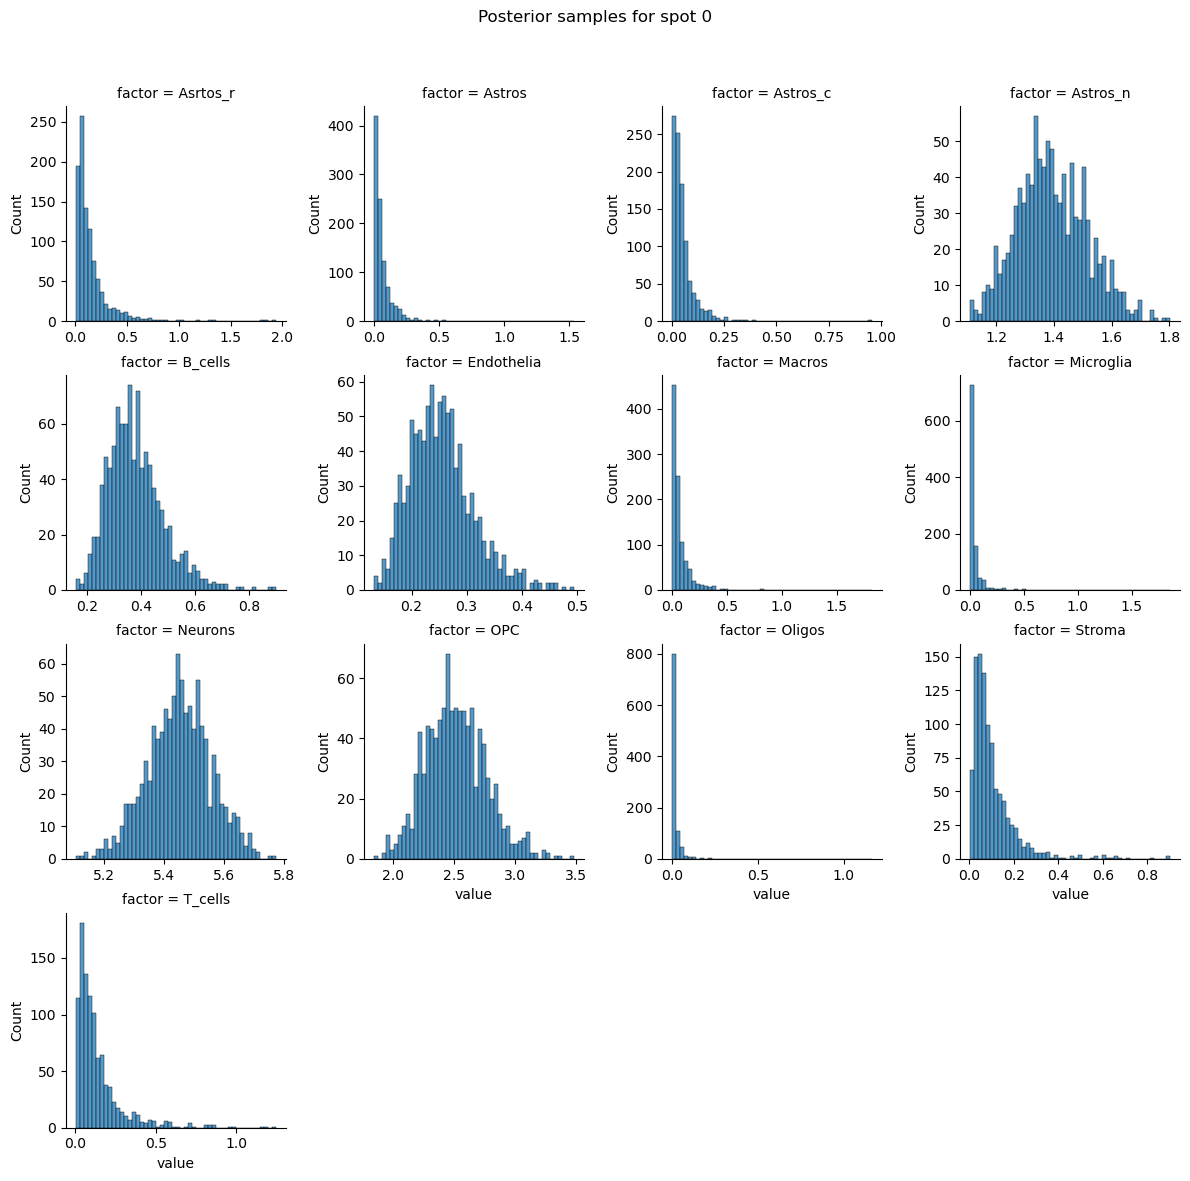

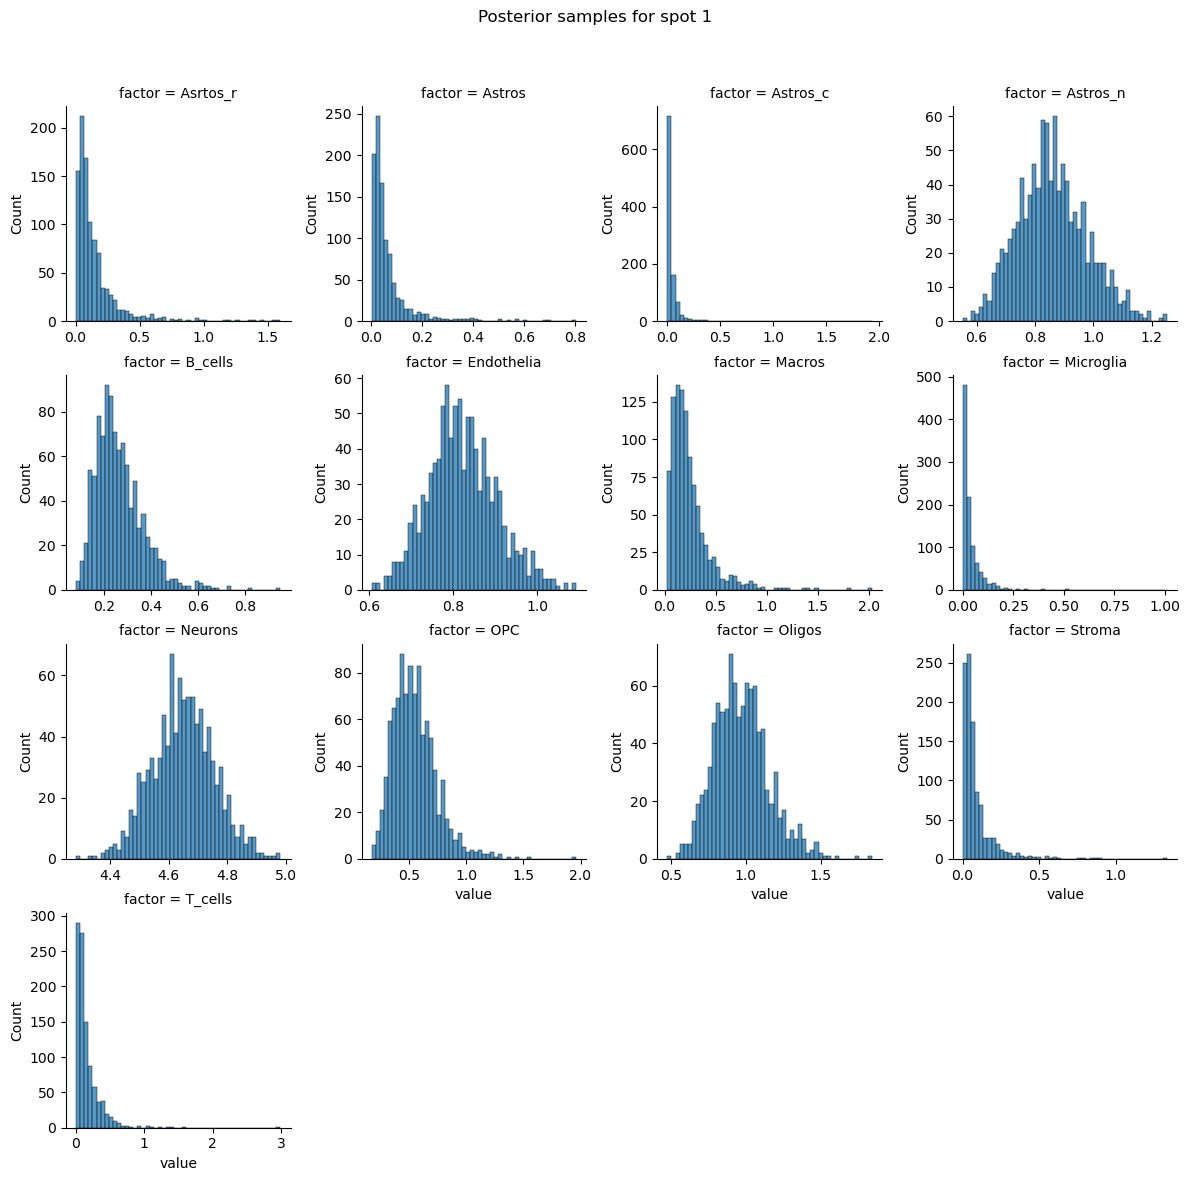

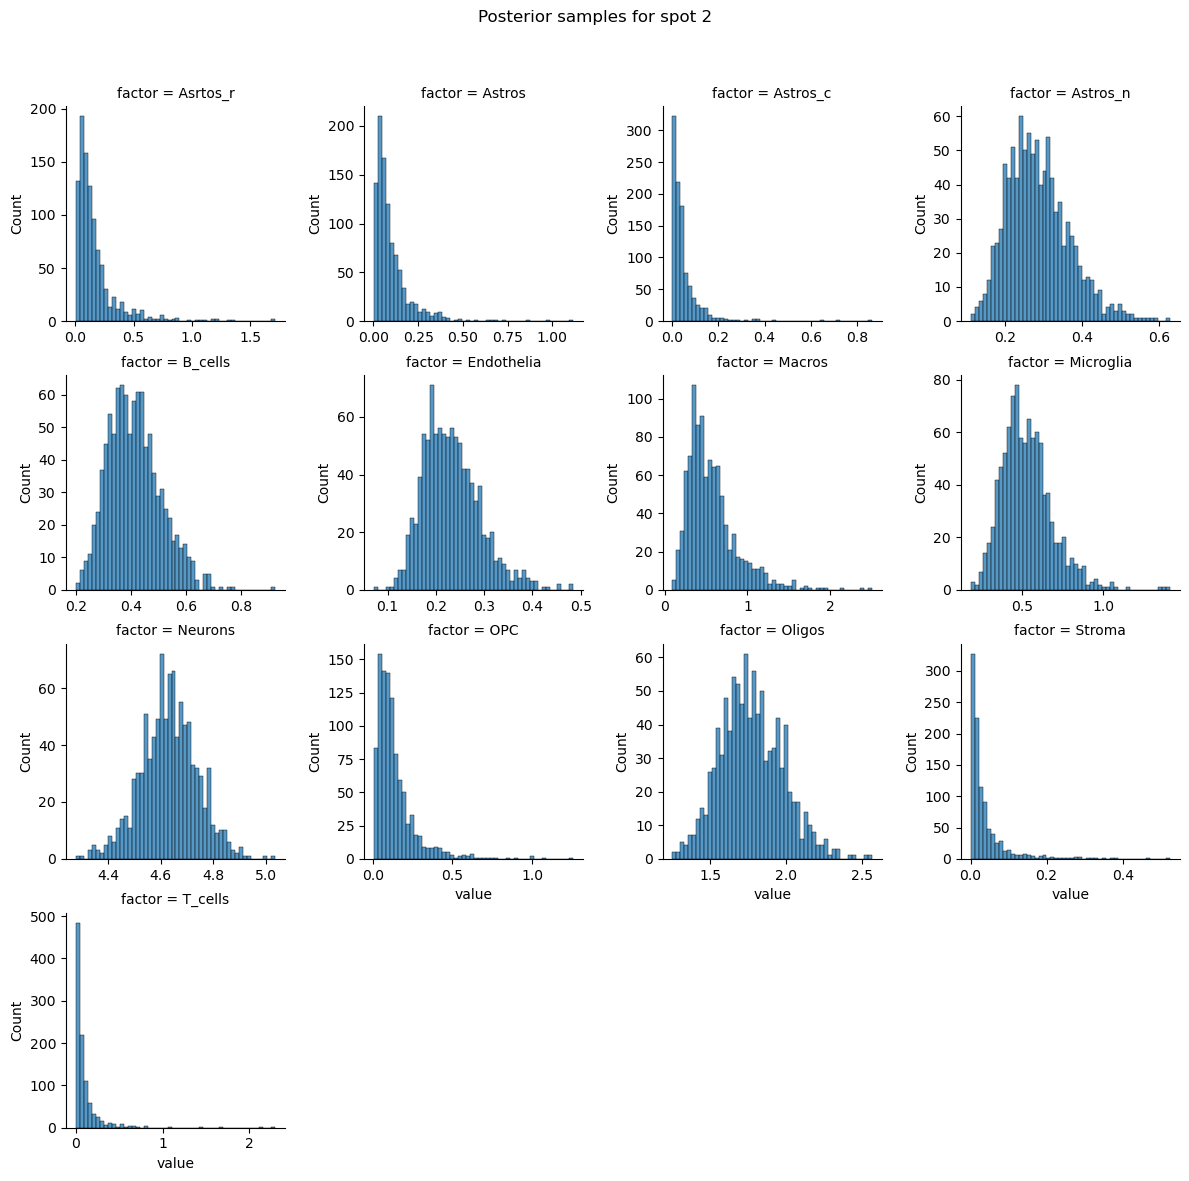

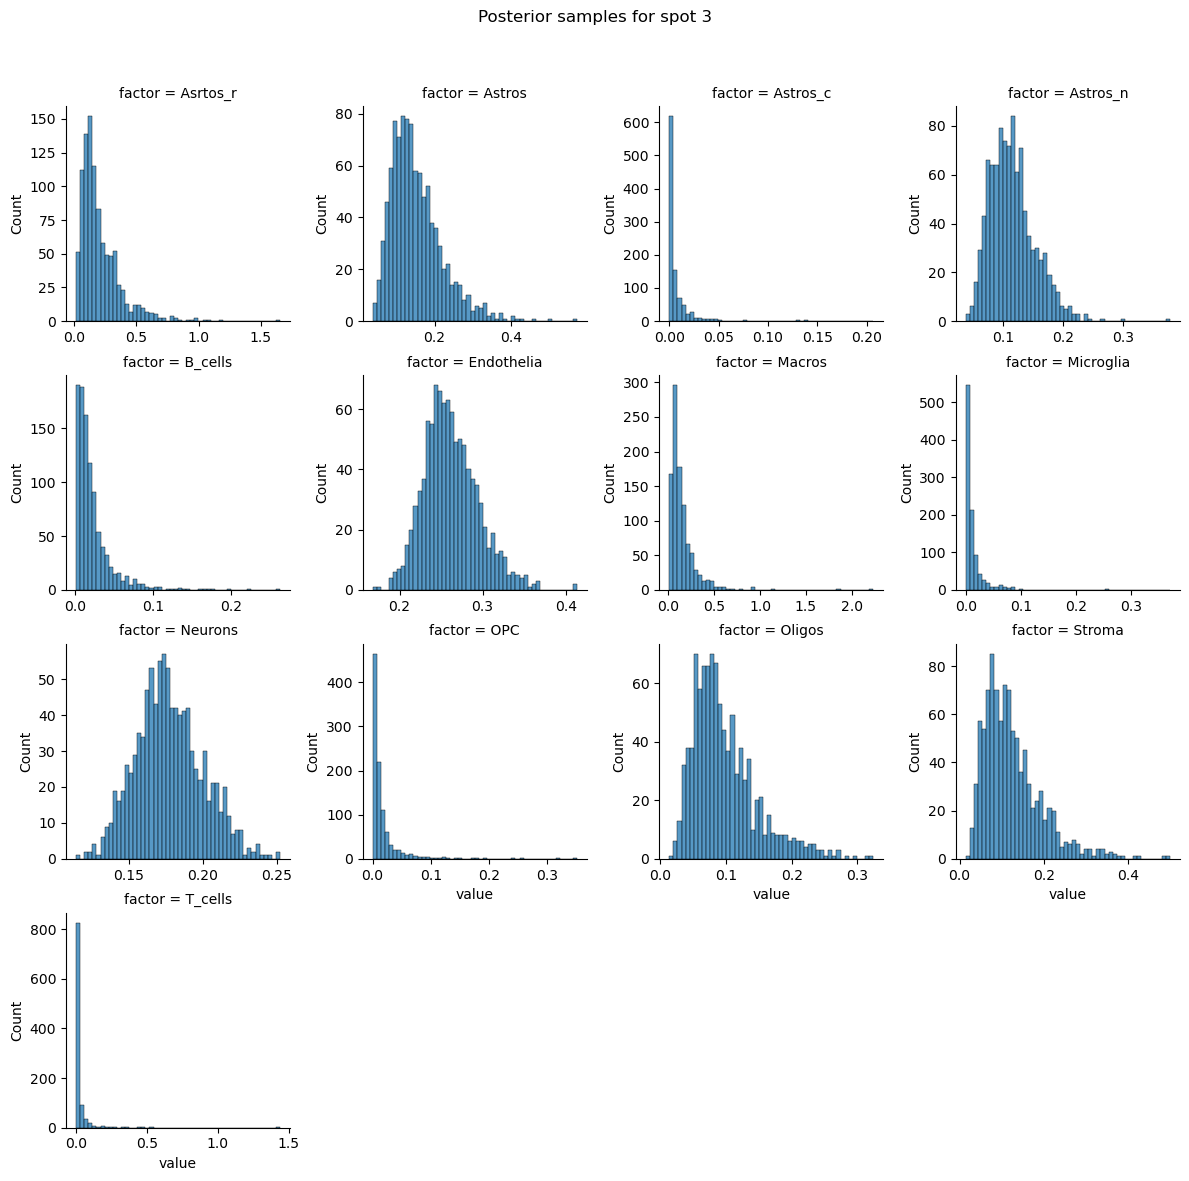

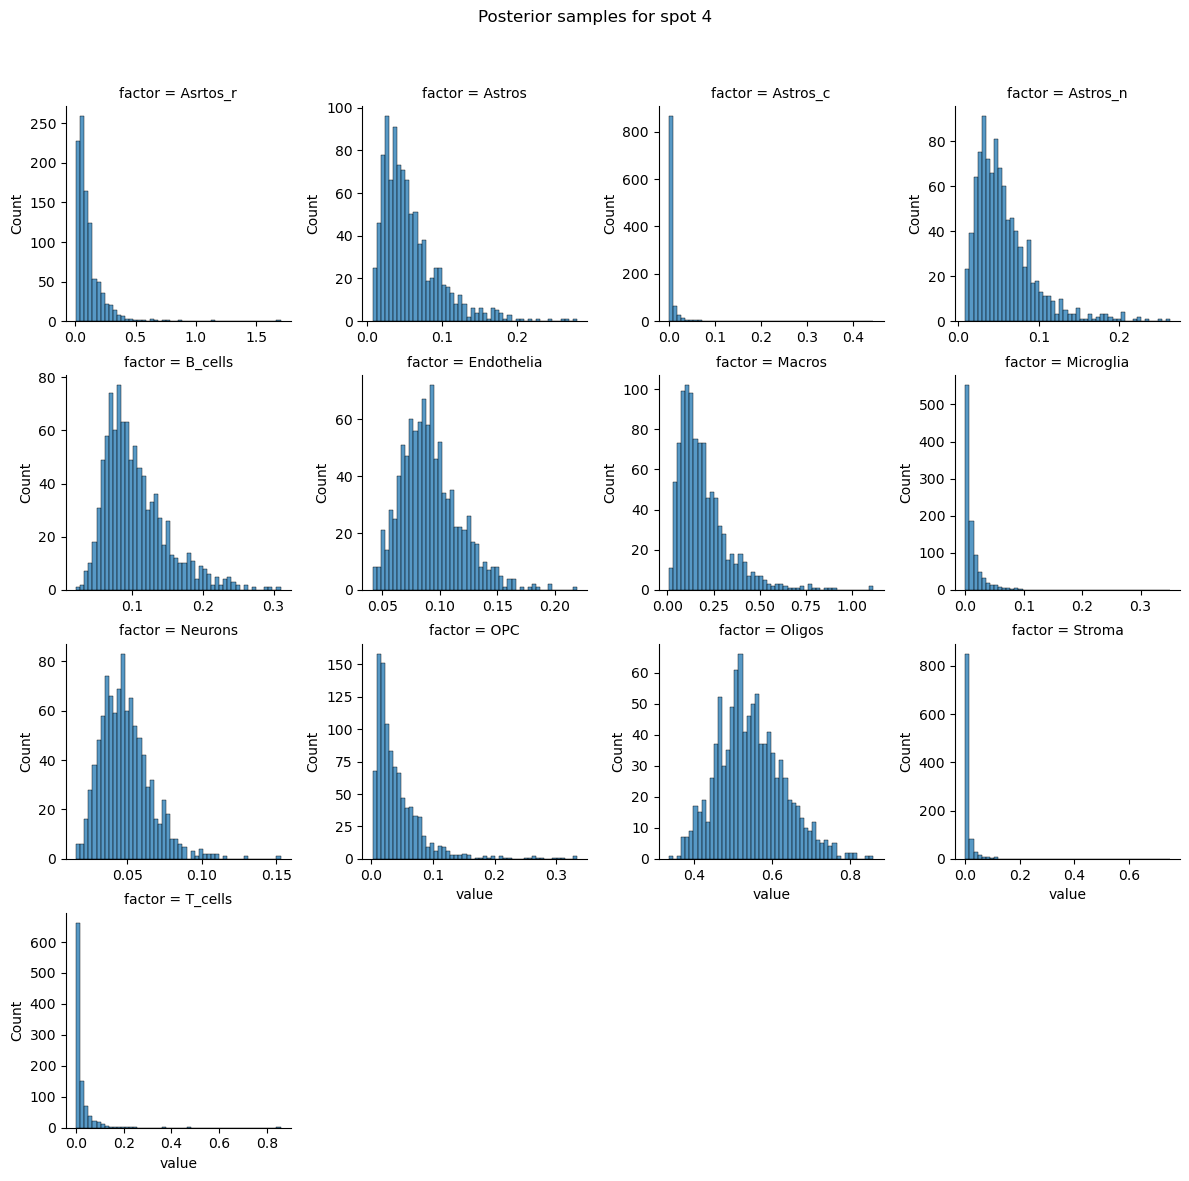

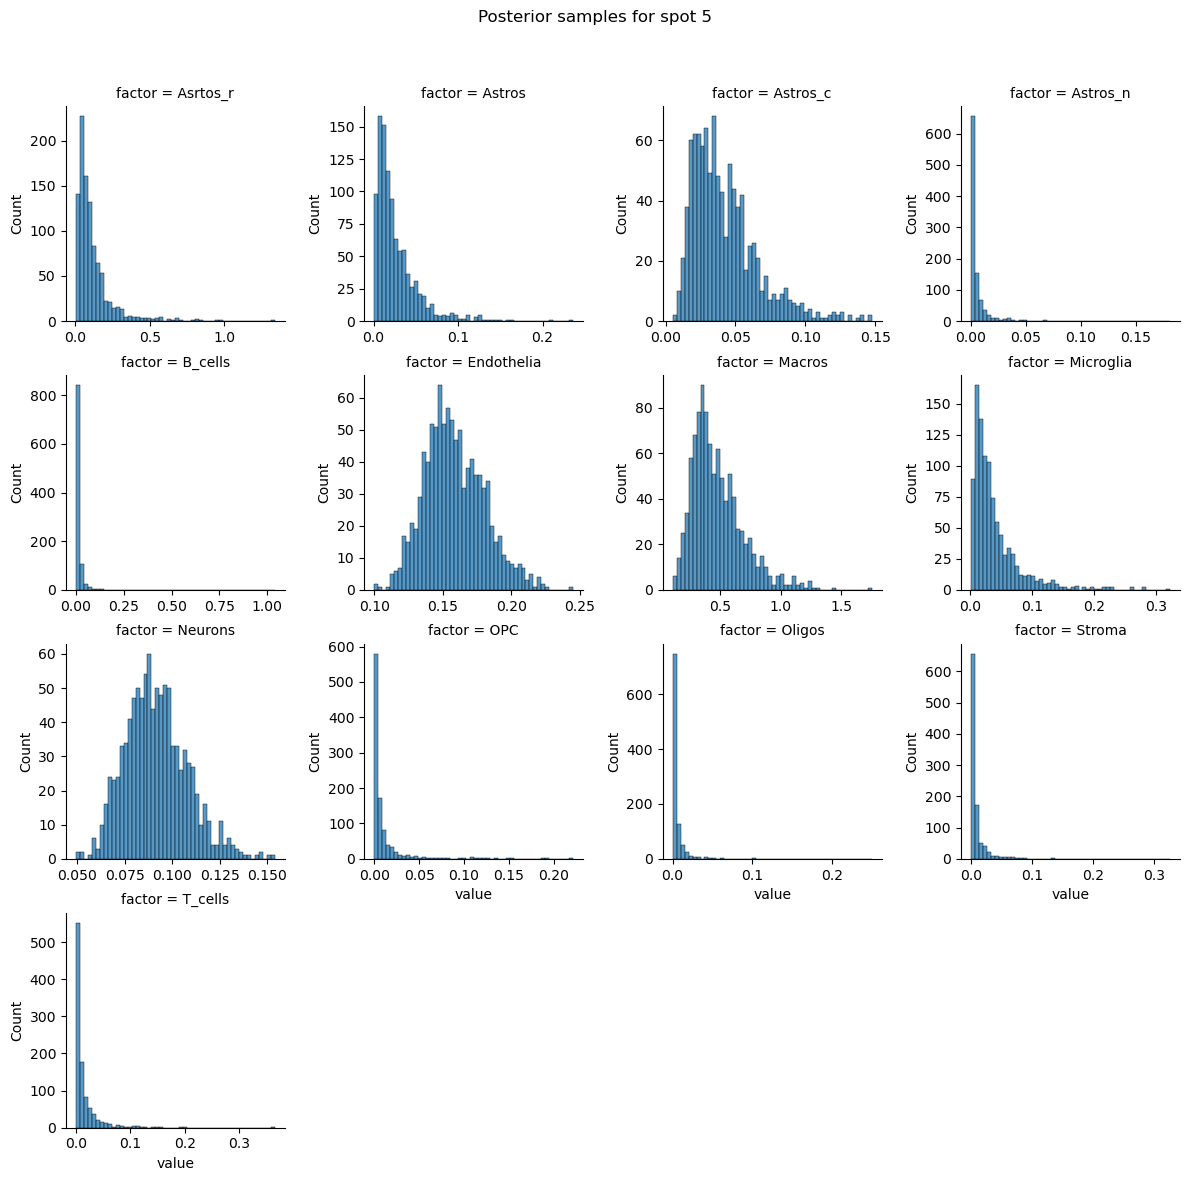

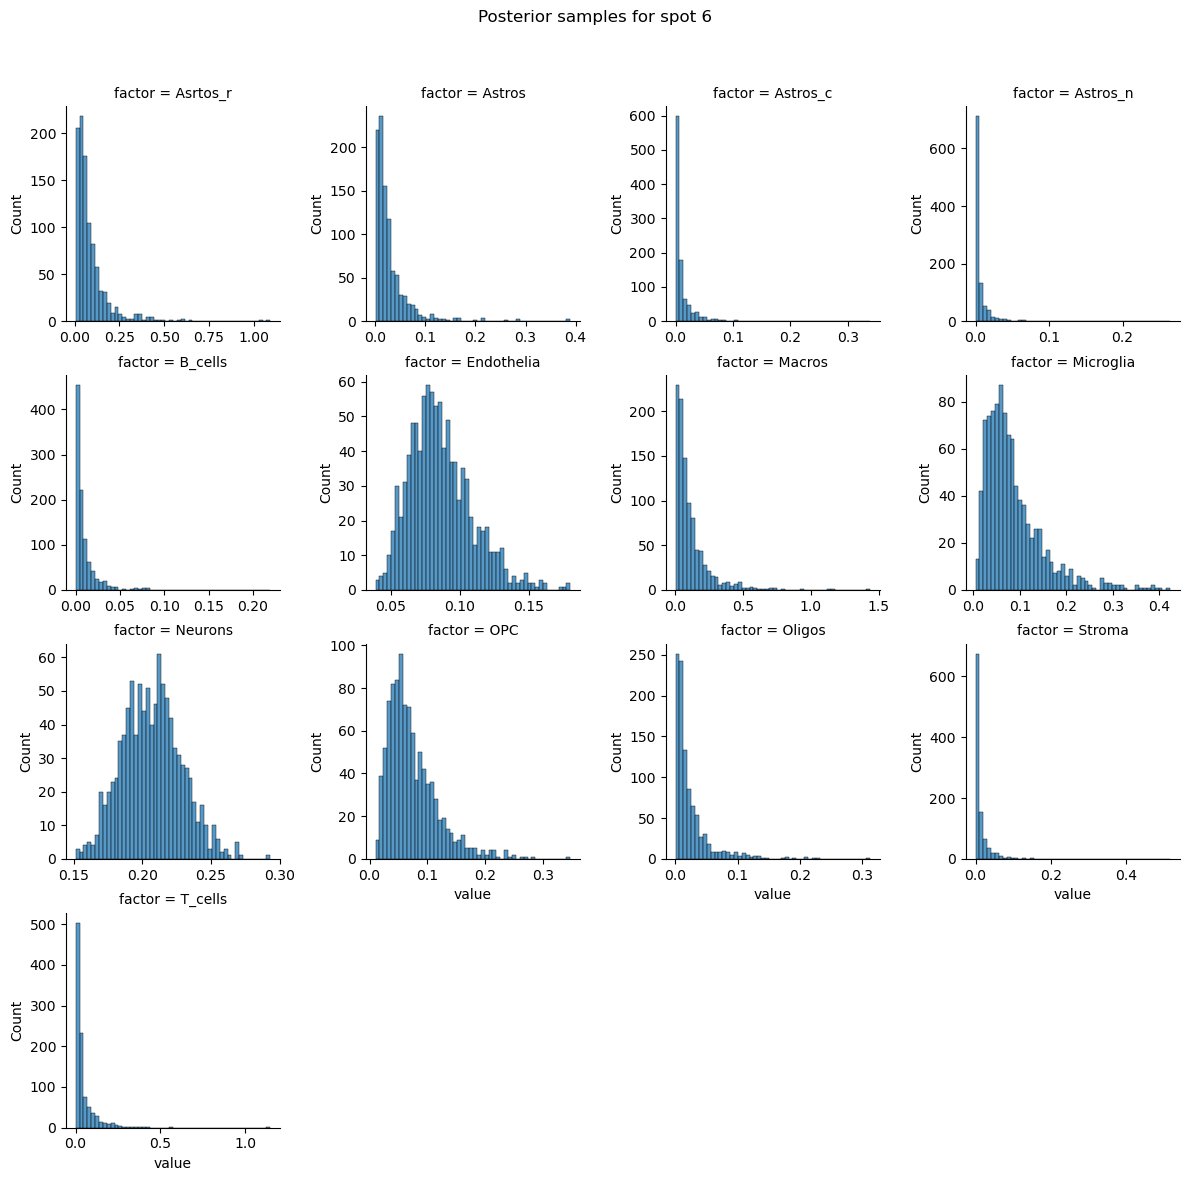

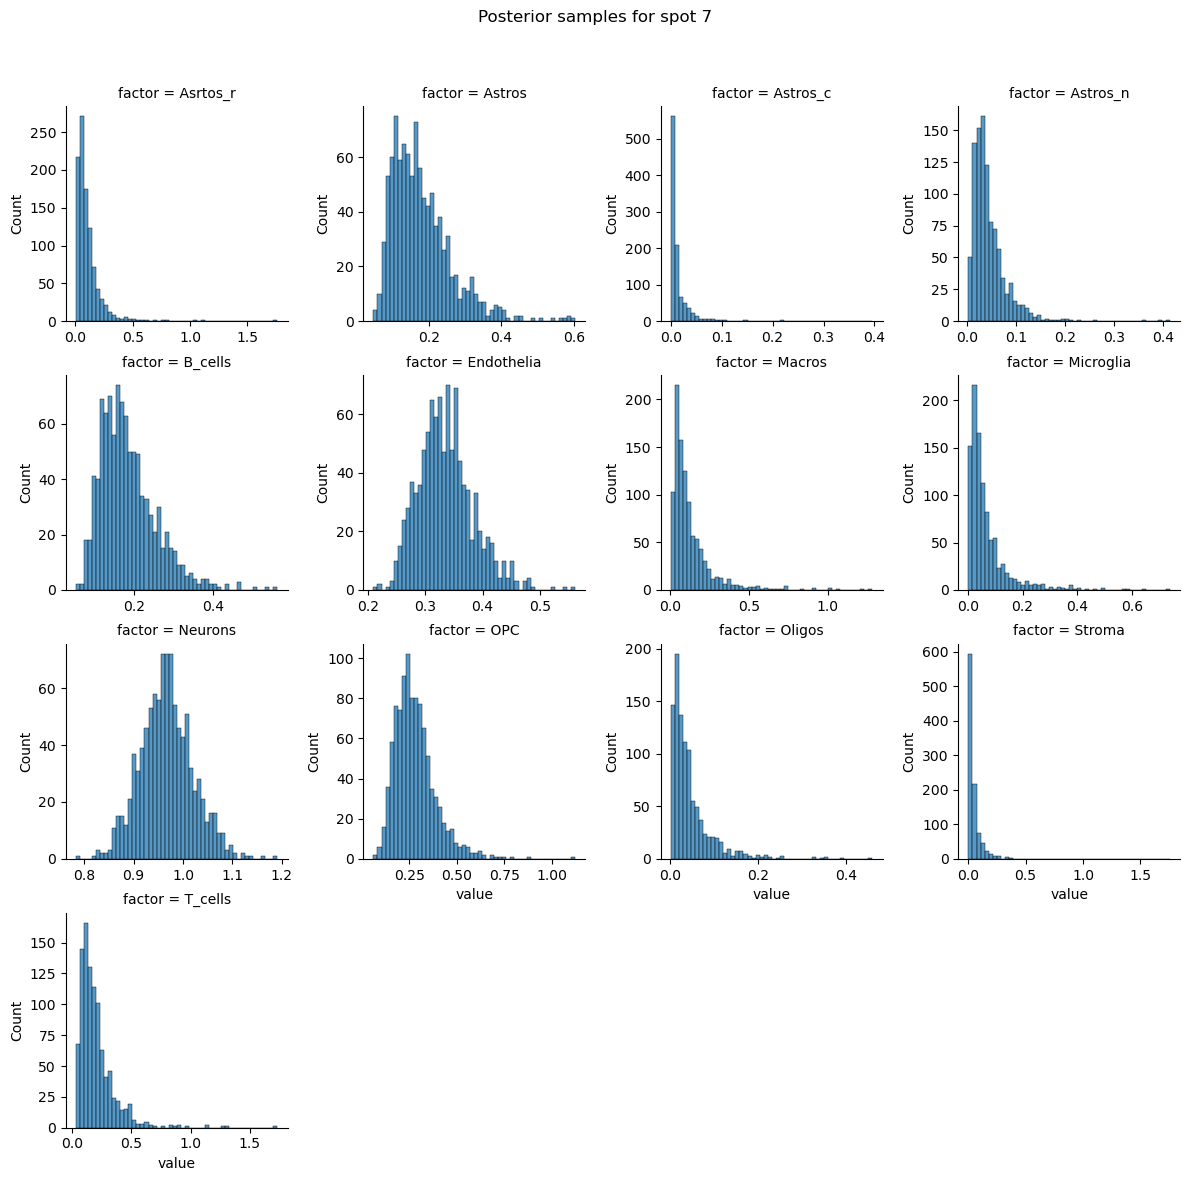

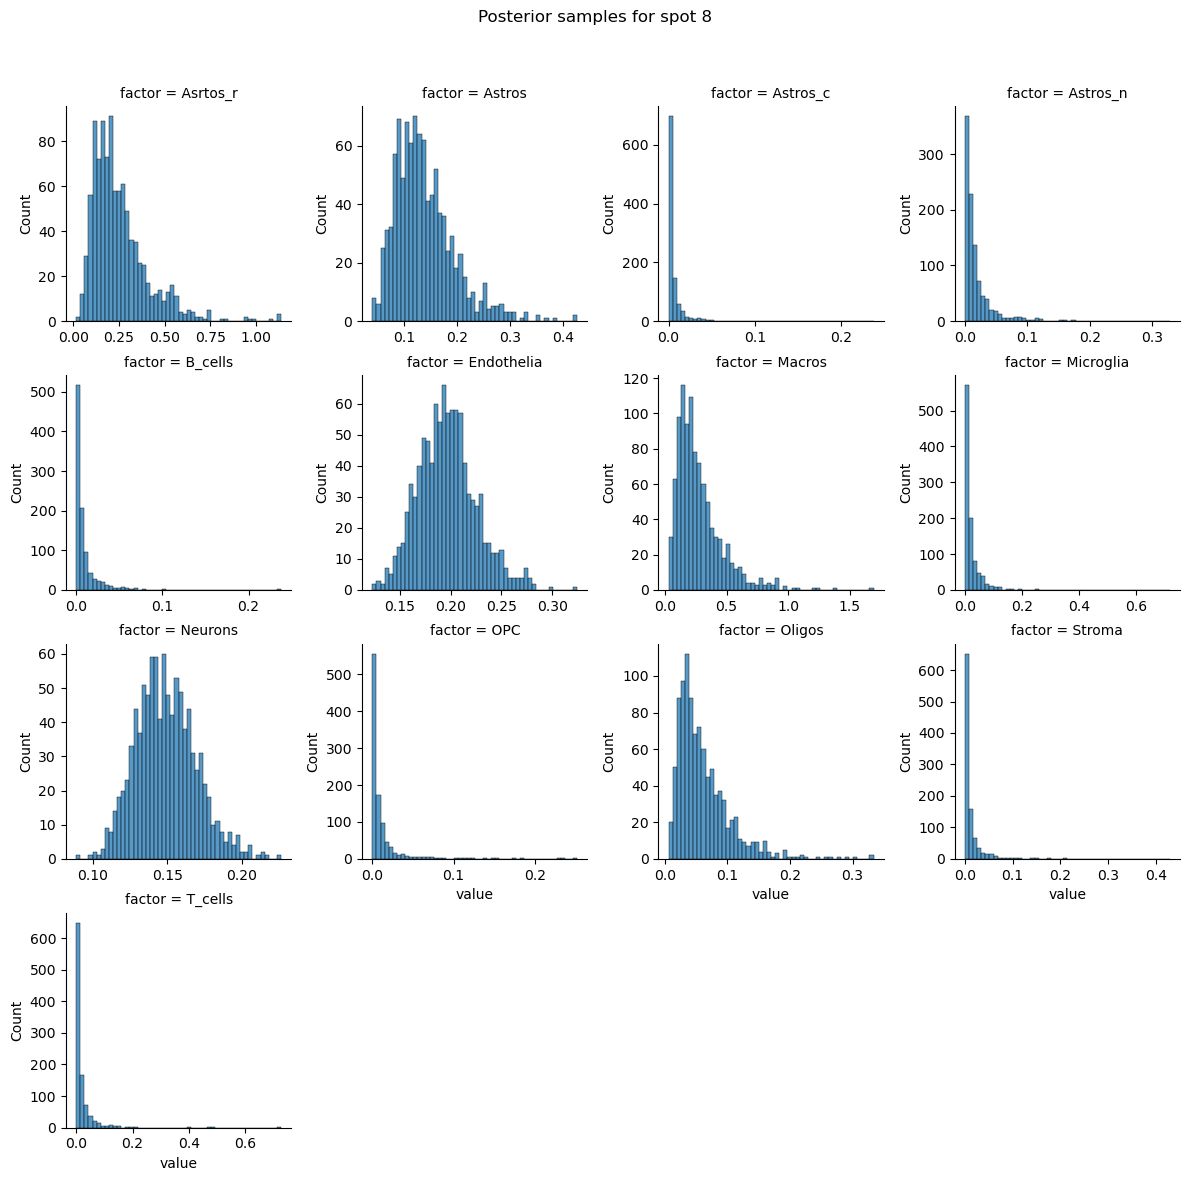

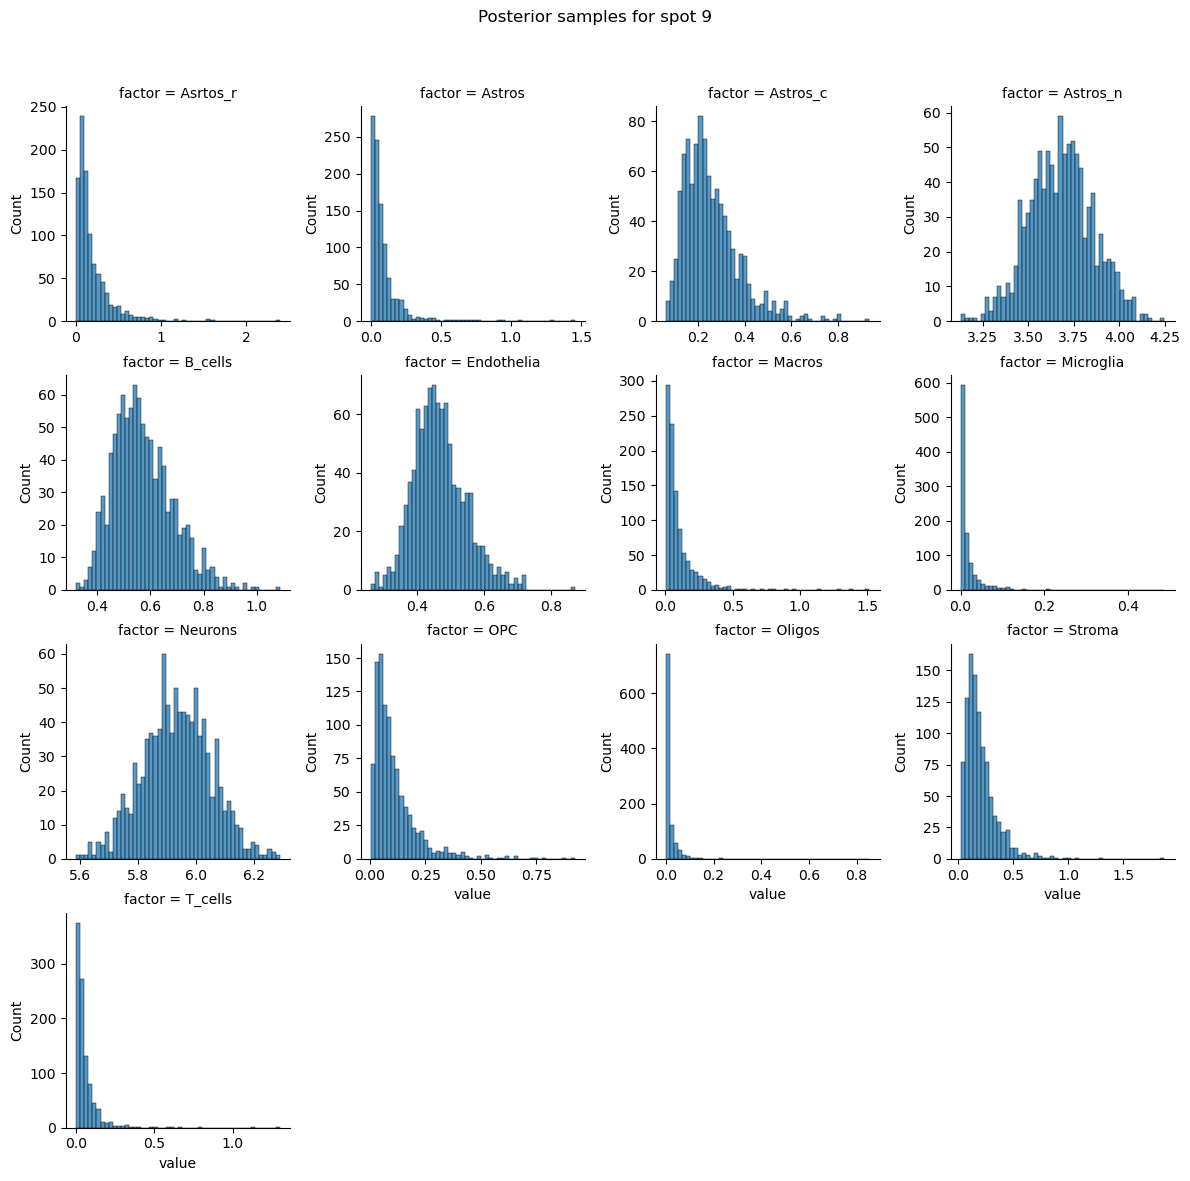

In [40]:
for i in range(10):
    df = pd.DataFrame(test["posterior_samples"]["w_sf"][:, i, :])
    df.columns = mod.factor_names_
    df = df.melt(var_name="factor", value_name="value")
    g = sns.FacetGrid(df, col="factor", col_wrap=4, sharex=False, sharey=False)
    g.map(sns.histplot, "value", bins=50)
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f"Posterior samples for spot {i}")
    plt.show()

In [29]:
df = pd.DataFrame(test["posterior_samples"]["w_sf"][:, 0, :])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.190832,0.075016,0.045169,1.346411,0.453892,0.344153,0.022984,0.013978,5.539934,2.746777,0.003767,0.003155,0.479739
1,0.134990,0.054470,0.033693,1.446502,0.270688,0.249465,0.150214,0.005023,5.655190,2.858062,0.131029,0.033882,0.175904
2,0.139949,0.111265,0.063853,1.511144,0.465158,0.416303,0.013988,0.010749,5.502213,2.619805,0.003123,0.077732,0.078964
3,0.050957,0.032600,0.027049,1.366441,0.284644,0.279619,0.140305,0.012660,5.517458,2.379888,0.005650,0.151332,0.253708
4,0.016913,0.074395,0.035197,1.324617,0.385461,0.339089,0.018212,0.015313,5.413667,2.471425,0.032845,0.113676,0.021331
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.078198,0.053021,0.017796,1.425147,0.338953,0.207022,0.136412,0.007561,5.518294,2.050508,0.045892,0.041579,0.237736
996,0.062588,0.154859,0.011938,1.416179,0.331631,0.310791,0.049229,0.004643,5.351063,2.834047,0.031595,0.027937,0.082623
997,0.241311,0.169105,0.019228,1.293342,0.338389,0.318611,0.285228,0.001044,5.635089,3.049536,0.046671,0.029326,0.019924
998,0.244095,0.054765,0.038996,1.322373,0.311410,0.320253,0.043154,0.015579,5.531794,2.827998,0.027502,0.023435,0.025696


In [17]:
# what variables do we have the posterior for?
mod.posterior_quantile([0.5]).keys()

dict_keys(['m_g_mean', 'm_g_alpha_e_inv', 'm_g', 'n_s_cells_per_location', 'b_s_groups_per_location', 'z_sr_groups_factors', 'k_r_factors_per_groups', 'x_fr_group2fact', 'w_sf', 'detection_mean_y_e', 'detection_y_s', 's_g_gene_add_alpha_hyp', 's_g_gene_add_mean', 's_g_gene_add_alpha_e_inv', 's_g_gene_add', 'alpha_g_phi_hyp', 'alpha_g_inverse'])

In [16]:
# median
mod.posterior_quantile([0.5])

{'m_g_mean': array([[0.9505955]], dtype=float32),
 'm_g_alpha_e_inv': array([[1.6529478]], dtype=float32),
 'm_g': array([[2.3270607 , 0.42177793, 1.3427668 , ..., 0.7845792 , 2.4511945 ,
         0.11596978]], dtype=float32),
 'n_s_cells_per_location': array([[5.433106 ],
        [5.615257 ],
        [5.2452016],
        ...,
        [6.462629 ],
        [7.1098905],
        [5.427057 ]], dtype=float32),
 'b_s_groups_per_location': array([[16.507242],
        [17.172825],
        [17.29427 ],
        ...,
        [16.317171],
        [16.416203],
        [17.132528]], dtype=float32),
 'z_sr_groups_factors': array([[0.0273842 , 0.02384534, 0.02714553, ..., 0.0249995 , 0.02551152,
         0.02742959],
        [0.03110715, 0.02858782, 0.02749502, ..., 0.02684044, 0.02936444,
         0.03306853],
        [0.02668387, 0.02610309, 0.02770692, ..., 0.02720583, 0.02804232,
         0.0270979 ],
        ...,
        [0.03890881, 0.03611962, 0.03671538, ..., 0.03484592, 0.0354903 ,
         0

In [17]:
#mod.export_posterior(adata_vis)
#mod.plot_QC()

Sampling global variables, sample: 100%|██████████| 999/999 [00:12<00:00, 78.51it/s]


AnnData object with n_obs × n_vars = 4691 × 18347
    obs: 'in_tissue', 'array_row', 'array_col', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [9]:
adata_vis.obsm_keys()

['means_cell_abundance_w_sf',
 'q05_cell_abundance_w_sf',
 'q95_cell_abundance_w_sf',
 'spatial',
 'stds_cell_abundance_w_sf']

In [54]:
adata_vis.obsm["means_cell_abundance_w_sf"]

,meanscell_abundance_w_sf_Asrtos_r,meanscell_abundance_w_sf_Astros,meanscell_abundance_w_sf_Astros_c,meanscell_abundance_w_sf_Astros_n,meanscell_abundance_w_sf_B_cells,meanscell_abundance_w_sf_Endothelia,meanscell_abundance_w_sf_Macros,meanscell_abundance_w_sf_Microglia,meanscell_abundance_w_sf_Neurons,meanscell_abundance_w_sf_OPC,meanscell_abundance_w_sf_Oligos,meanscell_abundance_w_sf_Stroma,meanscell_abundance_w_sf_T_cells
AAACAACGAATAGTTC-1,0.141533,0.074395,0.057693,1.389373,0.371965,0.252078,0.074936,0.034486,5.448067,2.497766,0.020644,0.108000,0.133393
AAACAAGTATCTCCCA-1,0.140880,0.057609,0.042461,0.875985,0.265544,0.818791,0.236236,0.041261,4.646664,0.548343,0.974400,0.086860,0.162282
AAACAATCTACTAGCA-1,0.162603,0.100504,0.054414,0.287490,0.416073,0.229798,0.569367,0.523791,4.626006,0.140650,1.763376,0.040281,0.087757
AAACACCAATAACTGC-1,0.212416,0.154111,0.008246,0.114683,0.023166,0.263177,0.149568,0.014412,0.175777,0.017545,0.097025,0.126834,0.022782
AAACAGAGCGACTCCT-1,0.106808,0.054435,0.005898,0.055334,0.101130,0.093084,0.211546,0.015368,0.048920,0.043852,0.548152,0.007602,0.027368
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0.486906,1.280757,0.365123,0.745319,1.311301,0.696471,1.424054,0.376429,1.288944,0.423173,5.326326,0.092136,0.128168
TTGTTTCATTAGTCTA-1,0.140015,0.042074,0.006614,0.009863,0.021703,0.225869,0.422706,0.033329,0.214066,0.018285,0.158779,0.036051,0.036172
TTGTTTCCATACAACT-1,0.099285,0.048736,0.007070,0.009920,0.132841,0.262188,0.157837,0.621601,0.158246,0.072293,0.067941,0.046580,0.090932
TTGTTTGTATTACACG-1,0.111123,0.159554,0.026408,0.071636,0.211996,0.612108,0.139528,0.218514,0.593053,0.028504,0.019844,0.101710,0.068921


In [55]:
adata_vis.obsm["q05_cell_abundance_w_sf"]

,q05cell_abundance_w_sf_Asrtos_r,q05cell_abundance_w_sf_Astros,q05cell_abundance_w_sf_Astros_c,q05cell_abundance_w_sf_Astros_n,q05cell_abundance_w_sf_B_cells,q05cell_abundance_w_sf_Endothelia,q05cell_abundance_w_sf_Macros,q05cell_abundance_w_sf_Microglia,q05cell_abundance_w_sf_Neurons,q05cell_abundance_w_sf_OPC,q05cell_abundance_w_sf_Oligos,q05cell_abundance_w_sf_Stroma,q05cell_abundance_w_sf_T_cells
AAACAACGAATAGTTC-1,0.020843,0.006291,0.008513,1.208197,0.230479,0.171203,0.006864,0.002258,5.280245,2.094112,0.000722,0.021168,0.019725
AAACAAGTATCTCCCA-1,0.020277,0.007133,0.004522,0.693296,0.137558,0.685317,0.059324,0.003263,4.471606,0.294428,0.719054,0.010841,0.025048
AAACAATCTACTAGCA-1,0.024196,0.017507,0.006101,0.166014,0.282583,0.150471,0.220170,0.302008,4.445678,0.029020,1.444132,0.002631,0.008479
AAACACCAATAACTGC-1,0.050091,0.067766,0.000219,0.062671,0.003247,0.212048,0.032473,0.000888,0.142294,0.000836,0.038255,0.046323,0.000736
AAACAGAGCGACTCCT-1,0.018553,0.016013,0.000041,0.018897,0.050006,0.055831,0.053975,0.000728,0.026366,0.008023,0.419976,0.000185,0.001165
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0.154478,1.009193,0.215266,0.552420,1.108003,0.570238,0.826410,0.184560,1.171168,0.206315,4.912071,0.013804,0.019479
TTGTTTCATTAGTCTA-1,0.031539,0.007572,0.000132,0.000495,0.002267,0.180666,0.159033,0.003611,0.177901,0.000649,0.075912,0.003739,0.001675
TTGTTTCCATACAACT-1,0.012806,0.008724,0.000215,0.000387,0.060419,0.212779,0.024991,0.462624,0.120942,0.016871,0.015672,0.003067,0.013701
TTGTTTGTATTACACG-1,0.017970,0.070819,0.001791,0.026503,0.120287,0.530129,0.021412,0.094094,0.524350,0.002366,0.000992,0.017940,0.005679


In [44]:
(adata_vis.obsm["stds_cell_abundance_w_sf"].to_numpy() / adata_vis.obsm["means_cell_abundance_w_sf"].to_numpy()).mean(axis=0)

array([1.0193034 , 0.8683895 , 1.4790019 , 0.9642297 , 0.50044006,
       0.16937205, 0.7374942 , 1.3209618 , 0.13935667, 1.0509717 ,
       0.7550675 , 1.5161741 , 1.5350567 ], dtype=float32)

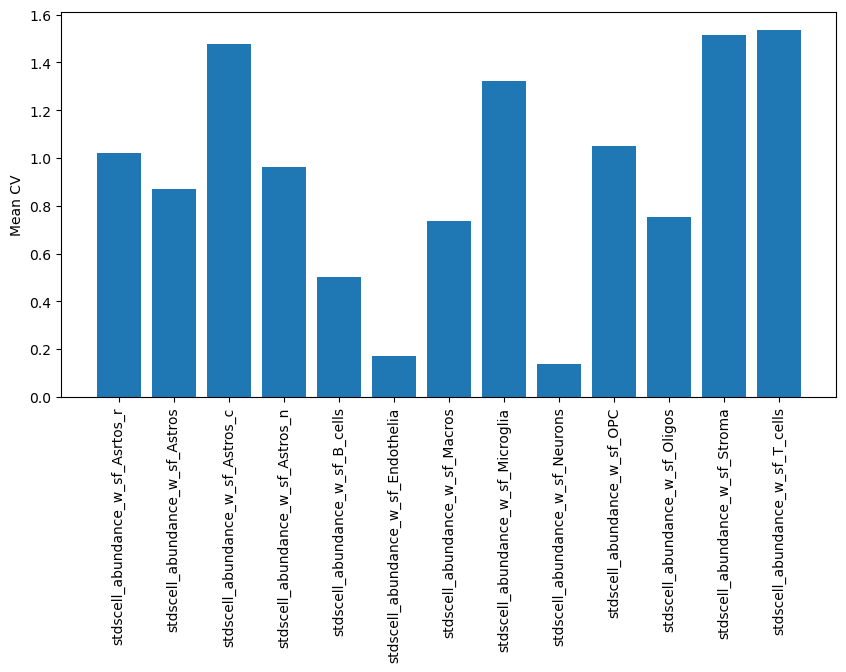

In [45]:
# coefficient of variation (CV) of the posterior distribution
mean_cv = (adata_vis.obsm["stds_cell_abundance_w_sf"].to_numpy() / adata_vis.obsm["means_cell_abundance_w_sf"].to_numpy()).mean(axis=0)
names = adata_vis.obsm["stds_cell_abundance_w_sf"].columns.tolist()
# barplot of cv values
plt.figure(figsize=(10, 5))
plt.bar(names, mean_cv)
plt.xticks(rotation=90)
plt.ylabel("Mean CV")
plt.show()

In [30]:
adata_vis.obsm["means_cell_abundance_w_sf"].mean(axis=0).values

array([0.19446634, 0.1744452 , 0.06146074, 0.58324206, 0.4477041 ,
       0.4282759 , 0.51057774, 0.14907098, 2.4555697 , 0.18669008,
       1.7963469 , 0.11899354, 0.09413076], dtype=float32)

In [27]:
cv = adata_vis.obsm["stds_cell_abundance_w_sf"].mean(axis=0) / adata_vis.obsm["means_cell_abundance_w_sf"].mean(axis=0)
cv

meanscell_abundance_w_sf_Asrtos_r     NaN
meanscell_abundance_w_sf_Astros       NaN
meanscell_abundance_w_sf_Astros_c     NaN
meanscell_abundance_w_sf_Astros_n     NaN
meanscell_abundance_w_sf_B_cells      NaN
meanscell_abundance_w_sf_Endothelia   NaN
meanscell_abundance_w_sf_Macros       NaN
meanscell_abundance_w_sf_Microglia    NaN
meanscell_abundance_w_sf_Neurons      NaN
meanscell_abundance_w_sf_OPC          NaN
meanscell_abundance_w_sf_Oligos       NaN
meanscell_abundance_w_sf_Stroma       NaN
meanscell_abundance_w_sf_T_cells      NaN
stdscell_abundance_w_sf_Asrtos_r      NaN
stdscell_abundance_w_sf_Astros        NaN
stdscell_abundance_w_sf_Astros_c      NaN
stdscell_abundance_w_sf_Astros_n      NaN
stdscell_abundance_w_sf_B_cells       NaN
stdscell_abundance_w_sf_Endothelia    NaN
stdscell_abundance_w_sf_Macros        NaN
stdscell_abundance_w_sf_Microglia     NaN
stdscell_abundance_w_sf_Neurons       NaN
stdscell_abundance_w_sf_OPC           NaN
stdscell_abundance_w_sf_Oligos    

In [ ]:
vis_prop_all

,sample_id,cell_types,vm_all
0,CO37,Asrtos_r,0.011303
1,CO40,Asrtos_r,0.004529
2,CO41,Asrtos_r,0.007057
3,CO74,Asrtos_r,0.017453
4,CO85,Asrtos_r,0.004410
...,...,...,...
281,MS497T,T_cells,0.007346
282,MS549H,T_cells,0.004189
283,MS549T,T_cells,0.010906
284,MS586,T_cells,0.007460


In [20]:
adata_vis.obs[adata_vis.uns['mod']['factor_names']]

,Asrtos_r,Astros,Astros_c,Astros_n,B_cells,Endothelia,Macros,Microglia,Neurons,OPC,Oligos,Stroma,T_cells
AAACAACGAATAGTTC-1,0.019525,0.006743,0.009438,1.202370,0.235921,0.175086,0.006629,0.002298,5.288223,2.096573,0.000686,0.018458,0.018215
AAACAAGTATCTCCCA-1,0.021591,0.007753,0.004283,0.686635,0.138195,0.693747,0.056426,0.002948,4.452716,0.295833,0.703378,0.011703,0.024934
AAACAATCTACTAGCA-1,0.024858,0.016324,0.006862,0.167869,0.273826,0.150780,0.228472,0.315994,4.446364,0.026809,1.441338,0.002227,0.007884
AAACACCAATAACTGC-1,0.049812,0.067898,0.000249,0.064704,0.002962,0.212335,0.032550,0.000763,0.142808,0.000906,0.038516,0.045473,0.000686
AAACAGAGCGACTCCT-1,0.018522,0.015995,0.000060,0.017861,0.050526,0.057463,0.053400,0.000841,0.026927,0.007814,0.416936,0.000199,0.001029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0.156762,1.001319,0.221120,0.565119,1.108693,0.569138,0.827008,0.184127,1.181755,0.209987,4.895499,0.014494,0.021049
TTGTTTCATTAGTCTA-1,0.032219,0.007932,0.000108,0.000481,0.001925,0.181511,0.164698,0.003695,0.178333,0.000700,0.078513,0.003728,0.001692
TTGTTTCCATACAACT-1,0.012178,0.008444,0.000194,0.000395,0.064437,0.211317,0.029193,0.466469,0.121863,0.015732,0.017205,0.002895,0.013991
TTGTTTGTATTACACG-1,0.016432,0.071915,0.001642,0.025178,0.116863,0.540993,0.022001,0.087018,0.522631,0.002000,0.001104,0.017699,0.005869
